<center> <h1> Lecture 4: Recommender Systems </h1> </center>
<center> Krishna Pillutla, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>



A recommender system seeks to predict the "rating" or "preference" a user would give to an item. Examples include:
 - online shopping sites (e.g., amazon.com)
 - music/movie services site (e.g., Netflix and Spotify) 
 - mobile application stores (e.g., IOS app store and Google play)
 - online advertising
 
The goal of recommender systems is to recommend those items to users which they would like.
The benefits are
- it helps reduce user effort in finding items (especially if there are too many items)
- it is a source of revenue for online businesses



This notebook has been adapted from the [D2L book](http://d2l.ai/chapter_recommender-systems/index.html).

## Collaborative Filtering
Collaborative filtering (CF) is probably the most common paradigm of recommender systems.  It is based on the idea that 
people *collaborate* with each other to *filter* products of interest. 

For instance, suppose that Charlie and Jackie both like a number of similar audio products such as speakers, headphones and so on. 
Charlie likes a new wireless headset which Jackie is not aware of. Chances are that Jackie will like it too. 

Collaborative filtering is based on **the previous behavior** of **similar users**.

We will focus on *model-based* collaborative filtering, which constructs 
attempts to model the user-item preferences and fits this model with data. 

**Explicit and Implicit Feedback**:
- In some applications, *explicit feedback* is available. For instance, when a user reviews a product on Amazon, likes a video on YouTube or a song on Spotify, and so on.
- On the other hand, one might only have to rely on *implicit feedback*, which is inferred from user behavior. For instance, a user clicked on an ad or a product recommendation, we use that to conclude that the user liked the product in question. Other examples include clicking a certain product on Amazon, duration a user watched a YouTube video and so on. 

**Downsides**:

- Explicit feedback is not always available as many users may be reluctant to rate products. 
- While implicit feedback is more readily available, it can be quite noisy. For instance, a user watched a movie does not necessarily indicate a positive view of that movie.
        
Often, one must use all kinds of feedback available in order to build a good recommender system.

## The MovieLens dataset

We will use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset, 
which contains the ratings (1-5) assigned to various movies by various users.

Suppose we have $m$ users and $n$ items. 
Usually, each user only sees a small number of items. Therefore, this 
user-item interaction matrix will be *extremely* sparse. 

In [1]:
import torch
import numpy as np
import os, sys, time 
import pandas as pd

import zipfile, tarfile, requests  # TODO: Ensure package requests is installed

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def download_and_extract_data(url):
    """Download and extract a zip/tar file."""
    #fname = download(name)
    fname = os.path.join('./data', url.split('/')[-1])
    if os.path.exists(fname):
        print(f'File {fname} already exists. Reading it')
    else:
        print(f'Downloading {fname} from {url}...')
        r = requests.get(url, stream=True, verify=True)
        with open(fname, 'wb') as f:
            f.write(r.content)
    
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    print('Done!')
    return data_dir

data_url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

def read_data_ml100k():
    data_dir = download_and_extract_data(data_url)
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items


In [3]:
data, num_users, num_items = read_data_ml100k()

Done!


/tmp/ipykernel_7824/1744849826.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


In [4]:
print(data.shape, num_users, num_items)
print(f'We have {data.shape[0]} ratings from {num_users} users and {num_items} items')
data.head(3)

(100000, 4) 943 1682
We have 100000 ratings from 943 users and 1682 items


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


To reduce the scale of the problem, we will subsample the dataset. 

In [5]:
num_users = 100
num_items = 500
# Users and items are numbered 1, 2, ...
data = data[(data['user_id'] <= num_users) & (data['item_id'] <= num_items)]
data.head(3)

,user_id,item_id,rating,timestamp
2,22,377,1,878887116
9,6,86,3,883603013
10,62,257,2,879372434


In [6]:
sparsity = 1 - len(data) / (num_users * num_items)
print(sparsity)

0.84916


Let us randomly split the data into train and test sets.

In [7]:
def split_data_ml100k(data, num_users, num_items, test_ratio=0.2):
    """Split the dataset randomly."""
    mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
    neg_mask = [not x for x in mask]
    train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

train_data, test_data = split_data_ml100k(data, num_users, num_items)
print(train_data.shape, test_data.shape)

(6035, 4) (1507, 4)


Let us format each sparse matrix into a [coordinate list](https://en.wikipedia.org/wiki/Sparse_matrix#Coordinate_list_(COO)) format.

In [9]:
def load_data_ml100k(data, num_users, num_items):
    users, items, scores = [], [], []
    for line in data.itertuples():
        # go from 1-based indexing (original data) to 0-based indexing (for Python)
        user_index, item_index = int(line[1] - 1), int(line[2] - 1) 
        score = int(line[3])
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
    return np.asarray(users), np.asarray(items), np.asarray(scores)

# iterate through zip(users, items, scores) to obtain each rating

train_users, train_items, train_scores = load_data_ml100k(train_data, num_users, num_items)
test_users, test_items, test_scores = load_data_ml100k(test_data, num_users, num_items)

# Ratings are maintained as a triple (users, items, scores)
# such that ratings[users[j], items[j]] = scores[j]

## Matrix Factorization

The principle underlying matrix factorization is that each user-item interaction rating 
is explained by a small number of *latent factors*. 

Suppose we have $m$ users and $n$ items.
Let $R \in \mathbb{R}^{m \times n}$ be a rating matrix where $R_{ui}$ denotes the rating 
given by user $u$ to item $i$. 

Concretely, each user $u$ can be described by a vector $p_u \in \mathbb{R}^f$ and each item $i$ can be described by a vector $q_i \in \mathbb{R}^f$. Then the rating given to item $i$ by user $u$ is simply the dot product
$$
    \hat R_{ui} = p_u^\top q_i + b_u + b_i \,,
$$
where $b_u, b_i \in \mathbb{R}$ are respectively the biases of user $u$ and item $i$.

Image credits: D2L.ai
![image](http://d2l.ai/_images/rec-mf.svg)


Stacking the user factors into a matrix $P \in \mathbb{R}^{m \times f}$ 
and item factors into a matrix $Q \in \mathbb{R}^{n \times f}$, this model can be written as 
$$
    \hat R = P Q^\top + {b_U} \vec{1}_n^\top + \vec{1}_m {b_I}^\top \,,
$$
where ${b_U} \in \mathbb{R}^m$ and ${b_I} \in \mathbb{R}^n$ are the bias vectors obtained by stacking each of the biases into a vector, and $\vec{1}$ denotes the vector of all ones. 

The objective is simply the square loss between the available ratings and the reconstructions (i.e., the reconstruction error):

$$
    \min_{P, Q, b_U, b_I} \frac{1}{N} \sum_{j=1}^N (R_{u_j, i_j} - \hat R_{u_j, i_j})^2 
         + \lambda ( \|P\|_F^2 + \|Q\|_F^2) \,,
$$
where $\lambda$ is a regularization parameter.

In [10]:
class MatrixFactorization(torch.nn.Module):
    # no batching
    def __init__(self, num_factors, num_users, num_items):
        super().__init__()
        # matrix factors
        self.P = torch.nn.Parameter(torch.randn(num_users, num_factors) * 1e-2)
        self.Q = torch.nn.Parameter(torch.randn(num_items, num_factors) * 1e-2)
        # bias vectors
        self.user_bias = torch.nn.Parameter(torch.zeros(num_users))
        self.item_bias = torch.nn.Parameter(torch.zeros(num_items))

    def forward(self, user_id, item_id): # user_id, item_id are integers
        p_u = self.P[user_id]
        q_i = self.Q[item_id]
        b_u = self.user_bias[user_id]
        b_i = self.item_bias[item_id]
        output = torch.dot(p_u, q_i) + b_u + b_i
        return output

# NOTE: In practice, we would always make a "batched" implementation.
# In other words, we would take in a list of user ids and item ids and
# return a list of outputs. This allows for use of minibatch SGD for training

**Evaluation**: We evaluate the model with the reconstruction error, as measured by the square loss (that is, the objective minus the regularization terms). 

In [11]:
@torch.no_grad()
def calculate_mse(users, items, scores, model):
    square_loss = 0.0
    for u, i, s in zip(users, items, scores):
        square_loss += (model(u, i).item() - s)**2
    return square_loss / len(users)  # average reconstruction error

@torch.no_grad()
def evaluate(users, items, scores, model, reg_param):
    mse = calculate_mse(users, items, scores, model)
    regularization = reg_param * (  # regularization
                torch.norm(model.P.view(-1))**2 +  # ||P||_F^2
                torch.norm(model.Q.view(-1))**2    # ||Q||_F^2
            ).item()
    objective = mse + regularization
    return objective, mse

@torch.no_grad()
def evaluate_all(model, reg_param):
    return [*evaluate(train_users, train_items, train_scores, model, reg_param),
            *evaluate(test_users, test_items, test_scores, model, reg_param)]

In [12]:
def sgd_one_pass(model, train_users, train_items, train_scores, 
                 rng, reg_param, learning_rate, verbose=True):
    randomly_shuffled_indices = rng.permutation(len(train_users))
    average_loss = 0.0
    for iteration_count, idx in enumerate(randomly_shuffled_indices):
        # select one user-item pair at random
        u, i, s = train_users[idx], train_items[idx], train_scores[idx]
        # compute (a stochastic estimate of) the objective using this pair
        objective = (
            (model(u, i) - s)**2 +  # square loss
            reg_param * (  # regularization
                torch.norm(model.P.view(-1))**2 +  # ||P||_F^2
                torch.norm(model.Q.view(-1))**2    # ||Q||_F^2
            )
        )
        log_freq = 500
        average_loss = (1 - 1/log_freq) * average_loss + (1/log_freq) * objective.item()
        if verbose and (iteration_count+1)%log_freq == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        
        # perform SGD update. Note: updates are performed inplace!
        with torch.no_grad():
            for (w, g) in zip(model.parameters(), gradients):
                w -= learning_rate * g
    return model

Find the divergent learning rate. 

In [14]:
rng = np.random.RandomState(1)
model = MatrixFactorization(num_factors=30, num_users=num_users, num_items=num_items)

learning_rate = 0.2
reg_param = 1e-5

print(evaluate_all(model, reg_param))

_ = sgd_one_pass(model, train_users, train_items, train_scores, 
                 rng, reg_param, learning_rate, verbose=True)

[14.91963356564628, 14.919615422477591, 14.81676540576639, 14.816747262597701]
2.405747997644659
2.278567609920007
1.8922755814244503
1.794047163691903
1.5408447951400794
1.6084932887408665
1.7107250369500318
2.321176307446478
nan
nan
nan
nan


Use the usual divergent learning rate heuristic to run 10 epochs through the data. 

In [15]:
rng = np.random.RandomState(1)
model = MatrixFactorization(num_factors=30, num_users=num_users, num_items=num_items)

learning_rate = 0.05
reg_param = 1e-3

logs = [evaluate_all(model, reg_param)]

print(0, '\t', *np.around(logs[-1], 3))  # round logs to 3 decimal places

for i in range(50):
    t1 = time.time()
    _ = sgd_one_pass(model, train_users, train_items, train_scores, 
                     rng, reg_param, learning_rate, verbose=False)
    logs.append(evaluate_all(model, reg_param))
    print(i+1, '\t', *np.around(logs[-1], 3), round(time.time() - t1, 2))


0 	 14.921 14.92 14.819 14.817
1 	 0.928 0.928 1.048 1.047 5.59
2 	 0.853 0.852 1.003 1.002 4.92
3 	 0.839 0.837 1.026 1.024 4.92
4 	 0.828 0.822 1.011 1.004 4.84
5 	 0.798 0.777 1.012 0.991 4.86
6 	 0.779 0.725 1.048 0.994 5.0
7 	 0.749 0.659 1.074 0.983 4.98
8 	 0.734 0.615 1.118 0.999 5.0
9 	 0.726 0.576 1.135 0.985 5.04
10 	 0.713 0.538 1.168 0.993 5.01
11 	 0.699 0.5 1.192 0.993 4.99
12 	 0.7 0.478 1.218 0.995 4.87
13 	 0.697 0.46 1.242 1.005 4.93
14 	 0.691 0.437 1.245 0.991 4.6
15 	 0.685 0.415 1.271 1.001 4.86
16 	 0.681 0.401 1.271 0.991 4.89
17 	 0.686 0.398 1.27 0.983 4.88
18 	 0.682 0.388 1.29 0.996 4.88


KeyboardInterrupt: 

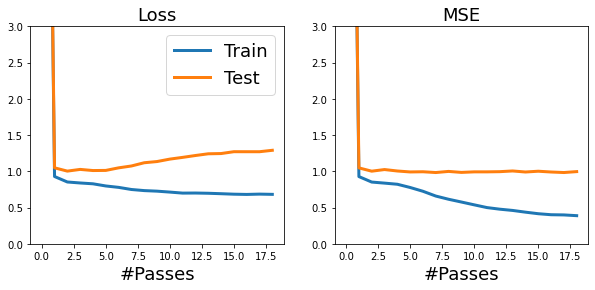

In [16]:
logs = np.asarray(logs)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logs[:, 0], label='Train', linewidth='3')
ax[0].plot(logs[:, 2], label='Test', linewidth='3')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_xlabel('#Passes', fontsize=18)

ax[1].plot(logs[:, 1], label='Train', linewidth='3')
ax[1].plot(logs[:, 3], label='Test', linewidth='3')
ax[1].set_title('MSE', fontsize=18)
ax[1].set_xlabel('#Passes', fontsize=18)

for a in ax: a.set_ylim((0, 3))

ax[0].legend(fontsize=18)

We can make a prediction for any user-item pair now.

In [17]:
predicted_rating = model(user_id=5, item_id=10)
print(predicted_rating.item())

3.842097043991089


## AutoRec: A deeper recommender system

AutoRec is a recommender system which uses neural networks to build a recommender system. 
The basic idea it to train a non-linear model to reconstruct the rating matrix. 
We train this model based on the available data in the matrix, and the reconstruction 
of the unavailable data for prediction. 

More precisely, let $r_i \in \mathbb{R}^m$ be the vector of ratings given to item $i$ from all users (i.e., it is a column of the rating matrix $R$). We will train a neural network to reconstruct $r_i$ using a small dimensional latent space (denoted here as "code"). Such a neural network is called an **autoencoder** -- we will play with autoencoders in greater detail in the lab. 

<!-- <img src="https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png" width="300"> -->

<div>
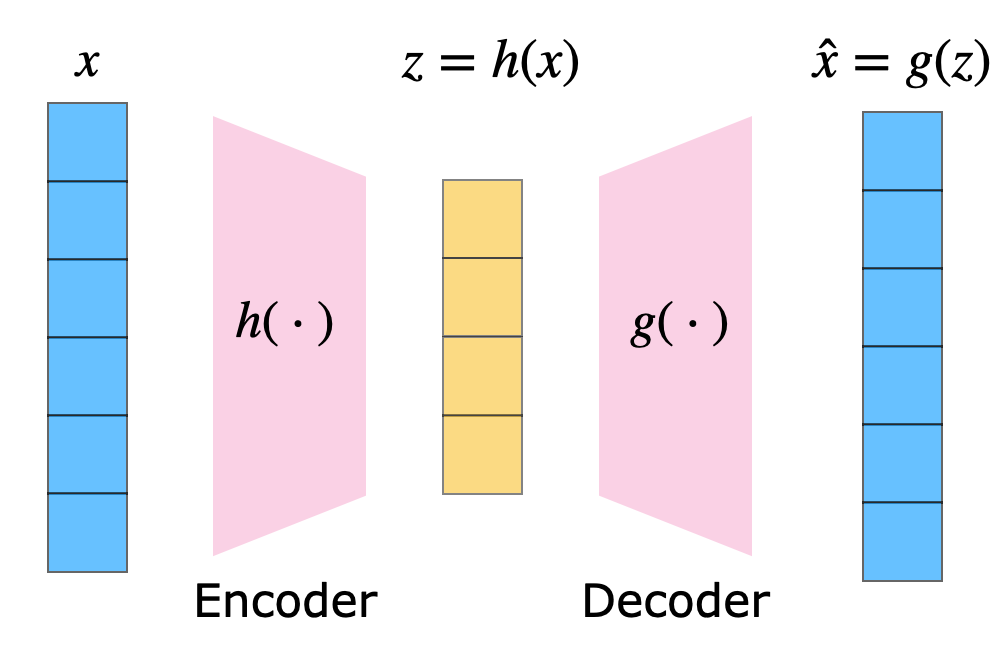
</div>

We will use the reconstructed output to make our predictions.

**Note**: We could have alternatively created an autoencoder on ratings given by a single user to all items (i.e., using rows of the rating matrix $R$). 


Reference:

    Sedhain, S., Menon, A. K., Sanner, S., & Xie, L. (2015). Autorec: autoencoders meet collaborative filtering. In Proc. WWW (pp. 111–112).


In [18]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, num_hidden, dropout=0.1):
        super().__init__()
        self.input_to_hidden = torch.nn.Linear(input_dim, num_hidden)
        # Note: output_dim = input_dim for an autoencoder
        self.hidden_to_output = torch.nn.Linear(num_hidden, input_dim)
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, columns, mask_unknowns=True):
        # expect "columns" of shape (input_dim,) or (batch_size, input_dim,)
        x = self.dropout(self.input_to_hidden(columns))  # first linear layer
        x = torch.nn.functional.relu(x)  # Activation
        x = self.hidden_to_output(x)  # second linear layer
        if mask_unknowns:
            # column only contains 0 (unknown ratings) or positive scores (known ratings)
            # torch.sign masks out unknown ratings for the purpose of training
            x = x * torch.sign(columns)
        return x
        

In [19]:
# Create the rating matrix with entries available for training. Others are zeros
train_matrix = torch.zeros(num_users, num_items)
for u, i, s in zip(train_users, train_items, train_scores):
    train_matrix[u, i] = s
print(train_matrix.shape)

torch.Size([100, 500])


In [20]:
@torch.no_grad()
def calculate_mse(predictions, users, items, scores):
    # predictions[u, i] is the prediction of the score for user u and item i
    mse = 0.0
    for u, i, s in zip(users, items, scores):
        mse += (predictions[u, i].item() - s)**2 / len(users)
    return mse

@torch.no_grad()
def evaluate_autorec(model, reg_param):
    model.eval()
    # call model in batched mode
    predictions = model(train_matrix.T, mask_unknowns=False).T   # (num_users, num_items)
    train_mse = calculate_mse(predictions, train_users, train_items, train_scores)
    test_mse = calculate_mse(predictions, test_users, test_items, test_scores)
    regularization = reg_param * (  # regularization
            np.linalg.norm([torch.norm(w.view(-1)).item() for w in model.parameters()])**2
            )
    train_objective = train_mse + regularization
    test_objective = test_mse + regularization
    return train_objective, train_mse, test_objective, test_mse


In [21]:
def sgd_one_pass(model, train_matrix,
                 rng, reg_param, learning_rate, verbose=True):
    model.train()
    average_loss = 0.0
    for idx in range(train_matrix.shape[1]):
        item = rng.randint(train_matrix.shape[1])
        column = train_matrix[:, item]
        number_of_ratings = (column > 0).sum().item()
        if number_of_ratings == 0:
            continue
        # pass through model
        reconstruction = model(column, mask_unknowns=True)
        # compute objective
        objective = (
            torch.norm((reconstruction - column).view(-1))**2 / number_of_ratings  + 
            reg_param * sum([torch.norm(w.view(-1))**2 for w in model.parameters()])
        )
        average_loss = 0.95 * average_loss + 0.05 * objective.item()
        if verbose and (idx + 1) % 50 == 0: 
            print(average_loss)
#             e1 = torch.norm((reconstruction - column).view(-1)).item()**2 / (number_of_ratings)
#             e2 = sum([torch.norm(w.view(-1))**2 for w in model.parameters()]).item()
#             print(objective.item(), e1, e2, number_of_ratings)
        # gradient
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        # SGD update
        with torch.no_grad():
            for w, g in zip(model.parameters(), gradients):
                w -= learning_rate * g
            

In [22]:
rng = np.random.RandomState(1)
model = AutoEncoder(input_dim=num_users, num_hidden=50)
reg_param = 1e-3
learning_rate = 0.01

# Initial performance
print(evaluate_autorec(model, reg_param))

for i in range(5):
    sgd_one_pass(model, train_matrix, rng, reg_param, learning_rate, verbose=True)

print(evaluate_autorec(model, reg_param))


(15.517463015089335, 15.465508828298667, 15.290086503328368, 15.2381323165377)
6.998927200303597
4.214021336725548
4.829922827238999
3.357241203050874
3.010133130679595
2.6996448324916558
2.7815760774281886
2.150368969710537
1.75223464351603
1.7579124215551867
1.696454854361451
1.5999584089078633
1.6730574008122316
1.3840167920226771
1.2216751912537749
1.2662496223839066
1.691557665341896
1.4221810354234437
1.2907180847716297
1.235214296466344
1.176984413819596
1.075090230408843
1.0387469784402004
0.8935132964572261
1.1192054377884249
1.0071711236417051
1.0127836066621885
1.090535980103481
1.0825242699574715
1.2140701879543505
0.801736284606505
0.8186655437983982
1.0428869037463797
0.8022163696451421
0.870289802152128
0.9251909890358254
0.893855196468262
0.8909376699406873
0.8349016974354756
0.8441121657767444
0.7521126932104152
0.6482492613433671
0.7903962516391037
0.8647009775566035
0.8697162190888769
0.9164189564541115
0.6982380047500878
0.8451291784569611
0.7262817630737314
0.91309

In [23]:
model = AutoEncoder(input_dim=num_users, num_hidden=50, dropout=0.75)
reg_param = 1e-3
learning_rate = 0.01

# Initial performance
logs = [evaluate_autorec(model, reg_param)]
print(0, '\t', *np.around(logs[-1], 3))

for i in range(500):
    sgd_one_pass(model, train_matrix, rng, reg_param, learning_rate, verbose=False)
    if (i+1) % 5 == 0:
        logs.append(evaluate_autorec(model, reg_param))
        print(i+1, '\t', *np.around(logs[-1], 3))


0 	 15.044 14.994 14.988 14.937
5 	 2.698 2.423 3.263 2.989
10 	 3.548 3.177 3.903 3.533
15 	 1.944 1.502 2.402 1.96
20 	 2.4 1.891 2.799 2.29
25 	 2.074 1.532 2.38 1.838
30 	 2.617 2.046 2.968 2.397
35 	 1.993 1.4 2.353 1.76
40 	 1.885 1.275 2.254 1.644
45 	 1.706 1.091 2.067 1.451
50 	 1.663 1.051 2.03 1.419
55 	 1.588 0.976 1.968 1.356
60 	 1.632 1.019 2.02 1.406
65 	 1.679 1.061 2.085 1.467
70 	 1.529 0.918 1.925 1.314
75 	 1.559 0.95 1.989 1.38
80 	 1.531 0.926 1.929 1.324
85 	 1.685 1.084 2.118 1.517
90 	 1.723 1.119 2.125 1.521
95 	 1.663 1.054 2.102 1.494
100 	 1.453 0.846 1.85 1.242
105 	 1.464 0.862 1.914 1.313
110 	 1.489 0.893 1.87 1.274
115 	 1.64 1.046 2.124 1.529
120 	 1.532 0.936 1.995 1.399
125 	 1.367 0.776 1.787 1.196
130 	 1.419 0.835 1.872 1.287
135 	 1.342 0.761 1.791 1.21
140 	 1.318 0.737 1.753 1.171
145 	 1.586 1.009 2.042 1.465
150 	 1.326 0.745 1.801 1.22
155 	 1.432 0.859 1.905 1.332
160 	 1.375 0.801 1.829 1.255
165 	 1.379 0.808 1.842 1.271
170 	 1.33 0.76

In [ ]:
logs = np.asarray(logs)

f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(logs[:, 0], label='Train', linewidth='3')
ax[0].plot(logs[:, 2], label='Test', linewidth='3')
ax[0].set_title('Loss', fontsize=18)
ax[0].set_xlabel('#Passes', fontsize=18)

ax[1].plot(logs[:, 1], label='Train', linewidth='3')
ax[1].plot(logs[:, 3], label='Test', linewidth='3')
ax[1].set_title('MSE', fontsize=18)
ax[1].set_xlabel('#Passes', fontsize=18)

for a in ax: a.set_ylim((0, 3))

ax[0].legend(fontsize=18)